# 4) Pretraining LLMs

In [2]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.8.2
numpy version: 1.26.4
tiktoken version: 0.7.0
torch version: 2.2.1+cu121


- In this notebook, we implement the training loop and code for basic model evaluation to pretrain an LLM

<img src="figures/01.png" width=700px>

<br>
<br>
<br>
<br>



# 4.1 Using GPT to generate text

- We initialize a GPT model using the code from the previous notebook

In [3]:
import torch
from supplementary import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 1024, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

We used a dropout rate of 0.1 before, but it's common now to train large language models (LLMs) without using dropout.
Newer LLMs don’t use bias vectors in certain layers (query, key, and value matrices) like older GPT models did. This is done by setting "qkv_bias": False.
To save on computing power during training, we shortened the context length to just 256 tokens, while the original GPT-2 model used 1024 tokens.

Next, we use the generate_text_simple function from the previous chapter to create text.
We also create two helper functions, text_to_token_ids and token_ids_to_text, to convert between text and token formats. We use these functions throughout this chapter.

<img src="figures/02.png" width=800px>

In [4]:
import tiktoken
from supplementary import generate_text_simple


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [5]:
start_context = ", Watson, that you have put "
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 , Watson, that you have put  textileumb resize 19 Rutgersjen Airport depri Willie Noticed


<br>

<br>
<br>
<br>
<br>



# 4.2 Preparing the dataset loaders

In [6]:
with open("/teamspace/studios/this_studio/Nov_22_output_sherlock_holmes_first_book.txt", "r", encoding="utf-8") as file:
    text_data = file.read()

- A quick check that the text loaded ok by printing the first and last 100 words

In [7]:
# First 100 characters
print(text_data[:99])

Sir Arthur Conan Doyle The Adventures of Sherlock Holmes 
 
 
   
   
 I. A Scandal in Bohemia 
 II


In [8]:
# Last 100 characters
print(text_data[-99:])

 with considerable success. 
 
 
 Publication Date: March 22nd 2008 https://www.bookrix.com/-gunnar


In [9]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 562489
Tokens: 136309


At 5,145 tokens, the text is too short for training a large language model, but it's meant for educational purposes (we will also load pretrained weights later).

Next, we split the dataset into training and validation sets, and use the data loaders from chapter 2 to prepare batches for training the LLM.
For illustration, the figure below assumes a max_length=6, but in the training loader, we set max_length to the context length that the LLM can handle.
The figure below only shows the input tokens for simplicity.
Since we train the LLM to predict the next word in the sequence, the target tokens are the same as the input tokens, but shifted by one position.

<img src="figures/03.png" width=1000px>

In [10]:
from supplementary import create_dataloader_v1


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [16]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 102

- Another optional check that the token sizes are in the expected ballpark:

In [11]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 120832
Validation tokens: 13312
All tokens: 134144


- Next, let's calculate the initial loss before we start training

In [12]:
from supplementary import calc_loss_loader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.985346907276218
Validation loss: 10.992926597595215


<br>
<br>
<br>
<br>



# 4.2 Training an LLM

- In this section, we finally implement the code for training the LLM

<img src="figures/04.png" width=600px>

In [13]:
from supplementary import (
    calc_loss_batch,
    evaluate_model,
    generate_and_print_sample
)


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

- Now, let's train the LLM using the training function defined above:

In [ ]:
torch.save(model.state_dict(), "sherlock_model.pth")

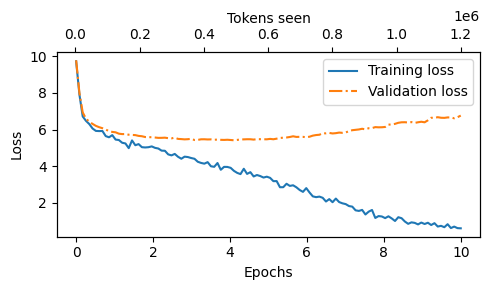

In [22]:
from supplementary import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Looking at the results above, we can see that the model starts by generating random, hard-to-understand words, but by the end, it produces sentences that are mostly correct grammatically.

However, from the training and validation set losses, we can tell that the model is beginning to overfit.

If we check some of the passages it writes towards the end, we’d find that they are directly copied from the training set—it’s just memorizing the data.

There are ways (not covered in this workshop) to reduce this memorization a bit.

Also, the overfitting happens because we have a very small training set, and we repeat it many times.

The training here is mainly for learning purposes. We just want to show that the model can generate coherent text.
Instead of spending a long time and a lot of resources training on huge datasets, we’ll load pretrained weights later.